In [1]:
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense
from tensorflow.keras.models import Sequential
import numpy as np
import tensorflow as tf
import pathlib
import cv2

In [3]:
batch_size = 32
img_height = 180
img_width = 180

In [4]:
training = tf.keras.utils.image_dataset_from_directory(
  'C:/Users/pragn/Downloads/dataset_T2MRI',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 624 files belonging to 14 classes.
Using 500 files for training.


In [5]:
validation = tf.keras.utils.image_dataset_from_directory(
  'C:/Users/pragn/Downloads/dataset_T2MRI',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 624 files belonging to 14 classes.
Using 124 files for validation.


In [6]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

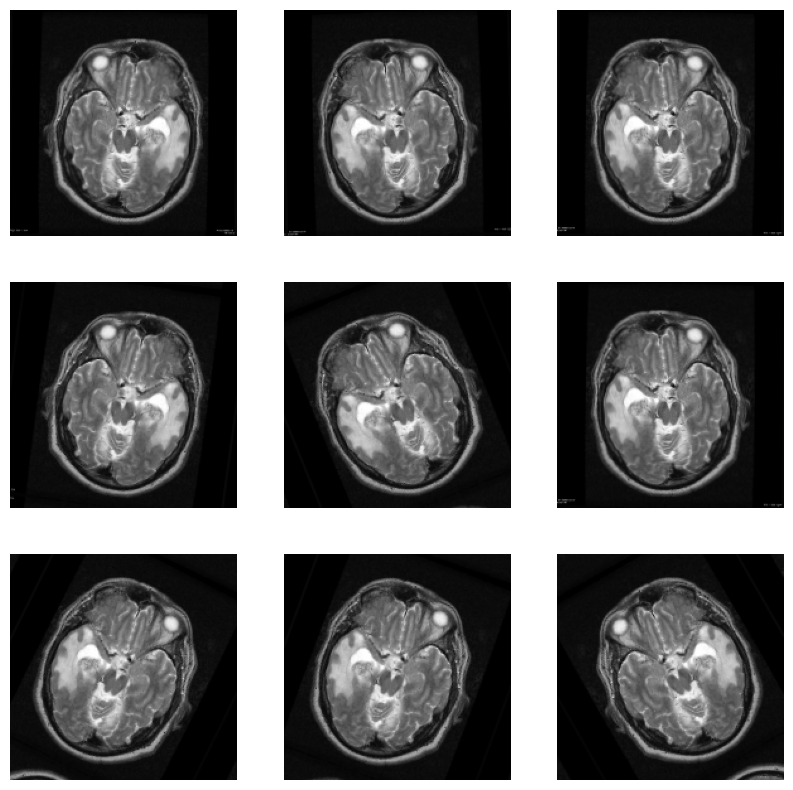

In [7]:
plt.figure(figsize=(10, 10))
for images, _ in training.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [9]:
classes = training.class_names
print(classes)

['Astrocytoma', 'Carcinoma', 'Ependimoma', 'Ganglioglioma', 'Germinoma', 'Glioblastoma', 'Granuloma', 'Meduloblastoma', 'Meningioma', 'Neurocitoma', 'Oligodendroglioma', 'Papiloma', 'Schwannoma', 'Tuberculoma']


In [10]:
for image_batch, labels_batch in training:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [11]:
AUTOTUNE = tf.data.AUTOTUNE
training = training.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation = validation.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
normlayer = layers.Rescaling(1./255)

In [24]:
normdata = training.map(lambda x, y: (normlayer(x), y))
image_batch, labels_batch = next(iter(normdata))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.99901235


In [25]:
numclass = len(classes)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(numclass)
])

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)       

In [28]:
epochs=19
history = model.fit(
  training,
  validation_data=validation,
  epochs=epochs)

Epoch 1/19
16/16 [==============================] - 10s 504ms/step - loss: 2.2778 - accuracy: 0.2760 - val_loss: 2.0107 - val_accuracy: 0.3226
Epoch 2/19
16/16 [==============================] - 7s 442ms/step - loss: 1.5174 - accuracy: 0.5480 - val_loss: 1.3894 - val_accuracy: 0.6129
Epoch 3/19
16/16 [==============================] - 7s 439ms/step - loss: 0.8211 - accuracy: 0.7780 - val_loss: 0.9965 - val_accuracy: 0.6694
Epoch 4/19
16/16 [==============================] - 7s 438ms/step - loss: 0.4219 - accuracy: 0.8820 - val_loss: 0.7601 - val_accuracy: 0.7903
Epoch 5/19
16/16 [==============================] - 7s 438ms/step - loss: 0.1533 - accuracy: 0.9540 - val_loss: 0.9403 - val_accuracy: 0.7742
Epoch 6/19
16/16 [==============================] - 7s 445ms/step - loss: 0.0740 - accuracy: 0.9760 - val_loss: 0.6701 - val_accuracy: 0.8629
Epoch 7/19
16/16 [==============================] - 7s 440ms/step - loss: 0.0608 - accuracy: 0.9780 - val_loss: 1.1267 - val_accuracy: 0.7903
Epoch

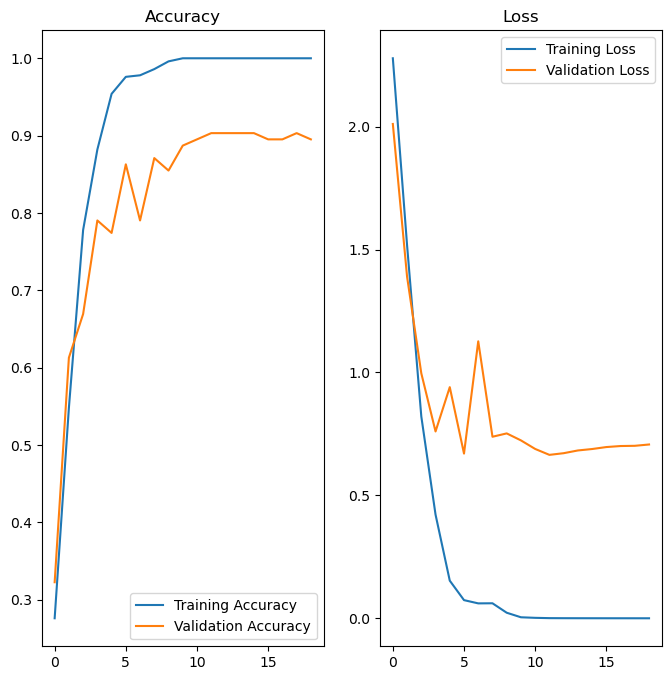

In [29]:
tacc = history.history['accuracy']
vacc = history.history['val_accuracy']

tloss = history.history['loss']
vloss = history.history['val_loss']

eprange = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(eprange, tacc, label='Training Accuracy')
plt.plot(eprange, vacc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(eprange, tloss, label='Training Loss')
plt.plot(eprange, vloss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

In [30]:
def prediction(datpath, model):
    img_height, img_width = 180, 180
    im = tf.keras.utils.load_img(datpath, target_size=(img_height, img_width))
    imarray = tf.keras.utils.img_to_array(im)
    imarray = tf.expand_dims(imarray, 0) 
    predict = model.predict(imarray)
    classindex = np.argmax(predict[0])
    return classindex

In [31]:
model.save('my_model.keras')
loaded_model = tf.keras.models.load_model('model.h5')

In [32]:
dat = 'C:/Users/pragn/Downloads/dataset_T2MRI/Astrocytoma/d027322a1208e770cfede03c6e0f9e54a28864696b6fc4446f49aefb8299fff1_big_gallery.jpeg'
mri = cv2.imread(dat)
classindex = prediction(dat, model)

1/1 [==============================] - 0s 253ms/step


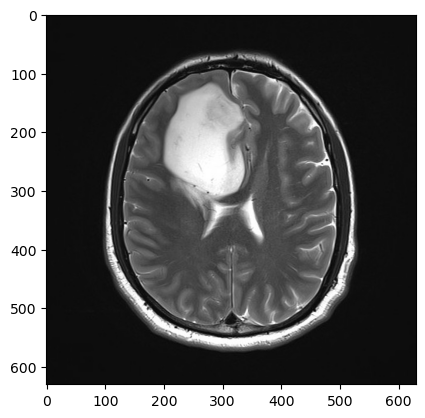

In [33]:
plt.imshow(mri)

In [34]:
seg = mri.reshape(-1, 3)
seg = np.float32(seg)

In [41]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3
_,labels,centers = cv2.kmeans(seg, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
labels = labels.reshape((mri.shape[:-1]))
redu = np.uint8(centers)[labels]

In [42]:
for i, c in enumerate(centers):
    mask = cv2.inRange(labels, i, i)
    mask = np.dstack([mask]*3) 
    tumor = cv2.bitwise_and(mri, mask)

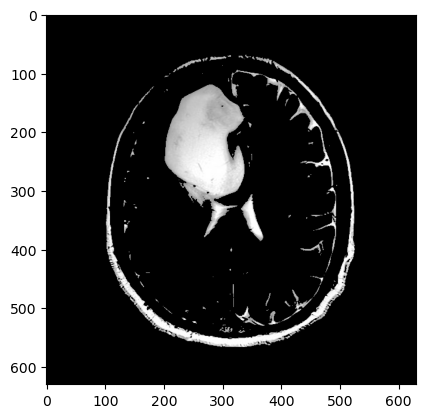

In [43]:
plt.imshow(tumor)

In [44]:
tum = tumor
grey = cv2.cvtColor(tum, cv2.COLOR_BGR2GRAY)
thresh = cv2.convertScaleAbs(grey)

contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
anomaly = max(contours, key=cv2.contourArea)

In [45]:
cv2.drawContours(tum, [anomaly], -1, (191, 54, 12), 3)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

NEUROSEG SUMMARY
-------------------------------------------
INTRACRANIAL TUMOR TYPE: Astrocytoma
TUMOR IDENTIFICATION VALIDATION ACCURACY: 90.32257795333862 %
TUMOR IDENTIFICATION TRAINING ACCURACY: 100.0 %


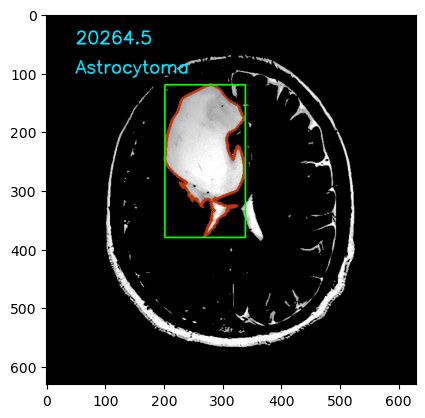

In [46]:
types = ['Astrocytoma', 'Carcinoma', 'Ependimoma', 'Ganglioglioma', 'Germinoma', 'Glioblastoma', 'Granuloma', 'Meduloblastoma', 'Meningioma', 'Neurocitoma', 'Oligodendroglioma', 'Papiloma', 'Schwannoma', 'Tuberculoma']
print("NEUROSEG SUMMARY")
print("-------------------------------------------")
print("INTRACRANIAL TUMOR TYPE: "+types[classindex])
systemvacc = max(vacc)
systemtacc = max(tacc)
print("TUMOR IDENTIFICATION VALIDATION ACCURACY: "+str(100*systemvacc)+' %')
print("TUMOR IDENTIFICATION TRAINING ACCURACY: "+str(100*systemtacc)+' %')

area = cv2.contourArea(anomaly)
x, y, w, h = cv2.boundingRect(anomaly) 
cv2.rectangle(tum, (x, y), (x+w, y+h), (0, 255, 0), 2) 

place1 = (50, 50)
place2 = (50, 100)
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 1
color = (10, 230, 255)
thickness = 2

cv2.putText(tum, str(area), place1, font, fontScale, color, thickness)
cv2.putText(tum, str(types[classindex]), place2, font, fontScale, color, thickness)

plt.imshow(tum)

In [47]:
lab = labels.ravel()

In [48]:
from sklearn.metrics import davies_bouldin_score
dbscore = davies_bouldin_score(seg, lab)
print(dbscore)

0.3484297837904742
